In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
import random
import plotly.express as px

random.seed(9000)

plt.style.use("seaborn-ticks")
plt.rcParams["image.cmap"] = "Set1"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)
%matplotlib inline

In this notebook we calculate `Percent Replicating` for a subset of the plates (U2OS at the longest time point) whose features were extracted using a pre-trained neural network.

In [2]:
n_samples = 1000
n_replicates = 4
cell = "U2OS"

corr_replicating_df = pd.DataFrame()
group_by_feature = 'Metadata_broad_sample'

experiment = {
    'ORF': {
        '96': {
            'BR00118039':'U2OS 96-hour ORF Plate 1',
            'BR00118040':'U2OS 96-hour ORF Plate 2'
        }
    },
    'CRISPR': {
        '144': {
            'BR00116997':'U2OS 144-hour CRISPR Plate 1',
            'BR00116998':'U2OS 144-hour CRISPR Plate 2',
            'BR00116999':'U2OS 144-hour CRISPR Plate 3',
            'BR00116996':'U2OS 144-hour CRISPR Plate 4'
        }
    },
    'Compound': {
        '48': {
            'BR00117012':'U2OS 48-hour Compound Plate 1',
            'BR00117013':'U2OS 48-hour Compound Plate 2',
            'BR00117010':'U2OS 48-hour Compound Plate 3',
            'BR00117011':'U2OS 48-hour Compound Plate 4'
        }
    }
}

experiment_name = "2020_11_04_CPJUMP1_DL"

In [3]:
for modality in experiment:
    experiment_df = pd.DataFrame()
    for time in experiment[modality]:
        for plate in experiment[modality][time]:
            data_df = (
                utils.load_data(experiment_name, plate, "augmented.csv.gz")
                .assign(Metadata_modality=modality)
                .assign(Metadata_experiment=f'{modality}_{cell}_{time}')
            )

            experiment_df = utils.concat_profiles(experiment_df, data_df) # create a single data frame for each modality

        experiment_df = utils.sphere_plate_zca_corr(experiment_df) # spherize the data
        experiment_df = utils.remove_negcon_empty_wells(experiment_df) # remove negative controls

        replicating_corr = list(utils.corr_between_replicates(experiment_df, group_by_feature)) # signal distribution
        null_replicating = list(utils.corr_between_non_replicates(experiment_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name = group_by_feature)) # null distribution

        prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating,
                                                                        replicating_corr,
                                                                        how='right')

        corr_replicating_df = corr_replicating_df.append({'Description':f'{modality}_{cell}_{time}',
                                                          'Modality':f'{modality}',
                                                          'Cell':f'{cell}',
                                                          'time':f'{time}',
                                                          'Replicating':replicating_corr,
                                                          'Null_Replicating':null_replicating,
                                                          'Percent_Replicating':'%.1f'%prop_95_replicating,
                                                          'Value_95':value_95_replicating}, ignore_index=True)

In [4]:
print(corr_replicating_df[['Description', 'Percent_Replicating']].to_markdown(index=False))

| Description      |   Percent_Replicating |
|:-----------------|----------------------:|
| ORF_U2OS_96      |                  41.9 |
| CRISPR_U2OS_144  |                  30.8 |
| Compound_U2OS_48 |                  59.5 |


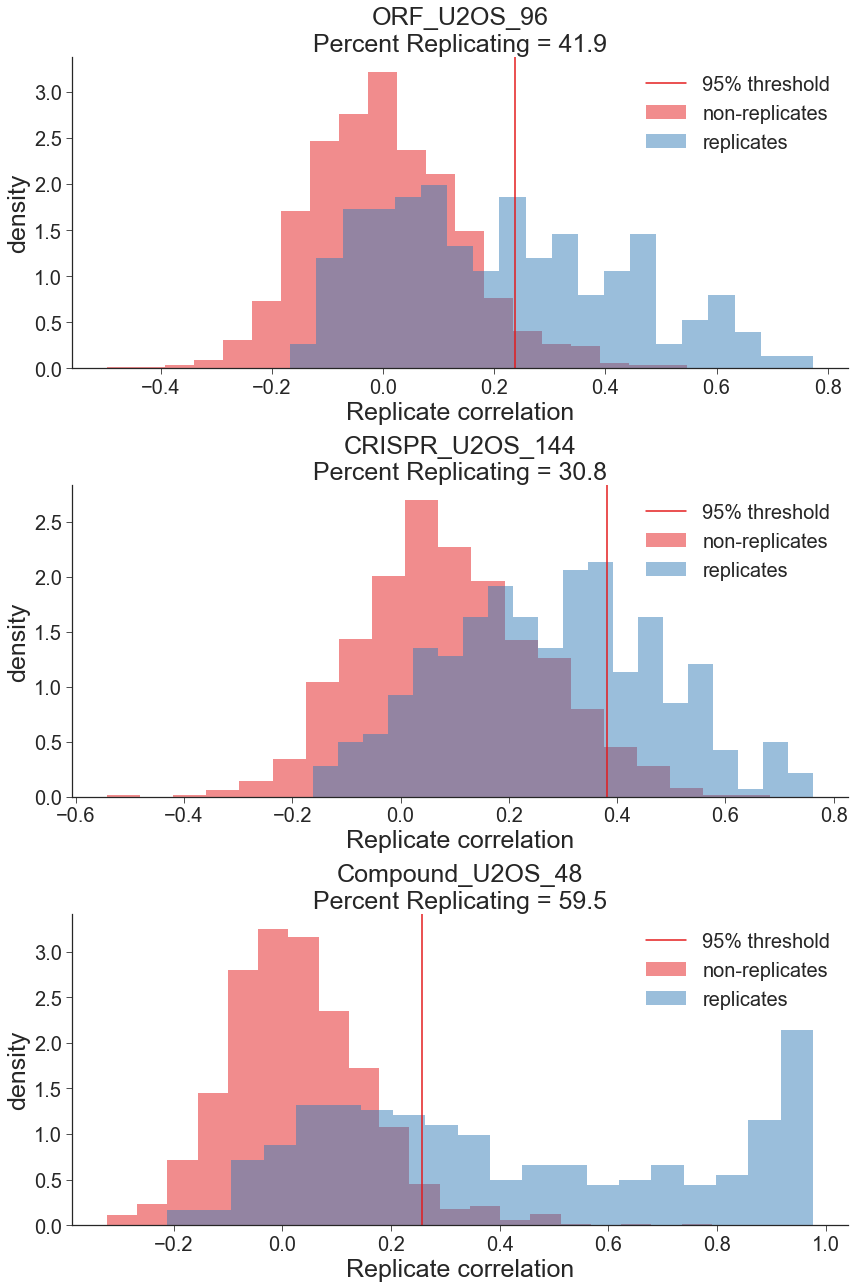

In [5]:
n_experiments = len(corr_replicating_df)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Replicate correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()
plt.savefig('figures/2.percent_replicating.png')

In [6]:
corr_replicating_df['Percent_Replicating'] = corr_replicating_df['Percent_Replicating'].astype(float)

corr_replicating_df.loc[(corr_replicating_df.Modality=='Compound') & (corr_replicating_df.time=='48'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='CRISPR') & (corr_replicating_df.time=='144'), 'time'] = 'long'
corr_replicating_df.loc[(corr_replicating_df.Modality=='ORF') & (corr_replicating_df.time=='96'), 'time'] = 'long'

plot_corr_replicating_df = (
    corr_replicating_df.rename(columns={'Modality':'Perturbation'})
    .drop(columns=['Null_Replicating','Value_95','Replicating'])
)

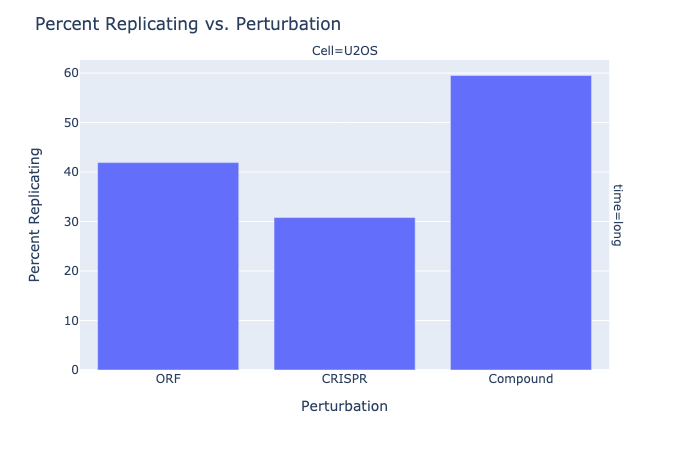

In [7]:
fig = px.bar(data_frame=plot_corr_replicating_df,
             x='Perturbation',
             y='Percent_Replicating',
             facet_row='time',
             facet_col='Cell')
fig.update_layout(title='Percent Replicating vs. Perturbation',
                  yaxis=dict(title='Percent Replicating'),
                  yaxis3=dict(title='Percent Replicating'))
fig.show("png")
fig.write_image(f'figures/2.percent_replicating_facet.png', width=640, height=480, scale=2)

In [8]:
print(plot_corr_replicating_df[['Description','Perturbation','time', 'Cell' ,'Percent_Replicating']].to_markdown(index=False))

| Description      | Perturbation   | time   | Cell   |   Percent_Replicating |
|:-----------------|:---------------|:-------|:-------|----------------------:|
| ORF_U2OS_96      | ORF            | long   | U2OS   |                  41.9 |
| CRISPR_U2OS_144  | CRISPR         | long   | U2OS   |                  30.8 |
| Compound_U2OS_48 | Compound       | long   | U2OS   |                  59.5 |
